# NammaMetro Ridership Data Analysis

In [ ]:
%pip install numpy
%pip install pandas
%pip install matplotlib.pyplot
%pip install seaborn

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

filename = "NammaMetro_Ridership_Dataset.csv"
df = pd.read_csv(filename, index_col=0)

## One Day on NammaMetro

#### Let's take a look at the daily ridership data that NammaMetro publishes

Source: [https://english.bmrc.co.in/ridership/](https://english.bmrc.co.in/ridership/)

The Namma Metro Ridership stats page publishes a breakdown of payment methods used daily by passengers entering the system.

![ridership_plot](nammametro_datapage.png)

### Earliest Record

In [22]:
df.head(1)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
0,26-10-2024,353460,352496,853,43,68,241883,7444,512,177279,49351,95571,32357


### Most Recent Record

In [23]:
df.tail(1)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
92,11-02-2025,420648,419995,230,57,366,182897,17151,293,157785,42958,84715,30112


#### Extend the table with two useful columns: `Day of Week` and `Total Riders`

In [24]:
df['Total Riders'] = df.loc[:, ['Total Smart Cards', 'Tokens', 'Total NCMC', 'Group Ticket', 'Total QR']].sum(axis=1).astype('Int64')
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%d-%m-%Y')
df['Day of Week'] = df['Record Date'].dt.day_name()

df[['Record Date', 'Day of Week', 'Total Riders']].tail(7)

,Record Date,Day of Week,Total Riders
86,2025-02-05,Wednesday,867660
87,2025-02-06,Thursday,864601
88,2025-02-07,Friday,870687
89,2025-02-08,Saturday,807651
90,2025-02-09,Sunday,623123
91,2025-02-10,Monday,828149
92,2025-02-11,Tuesday,778774


### Passenger Flow: First Glance

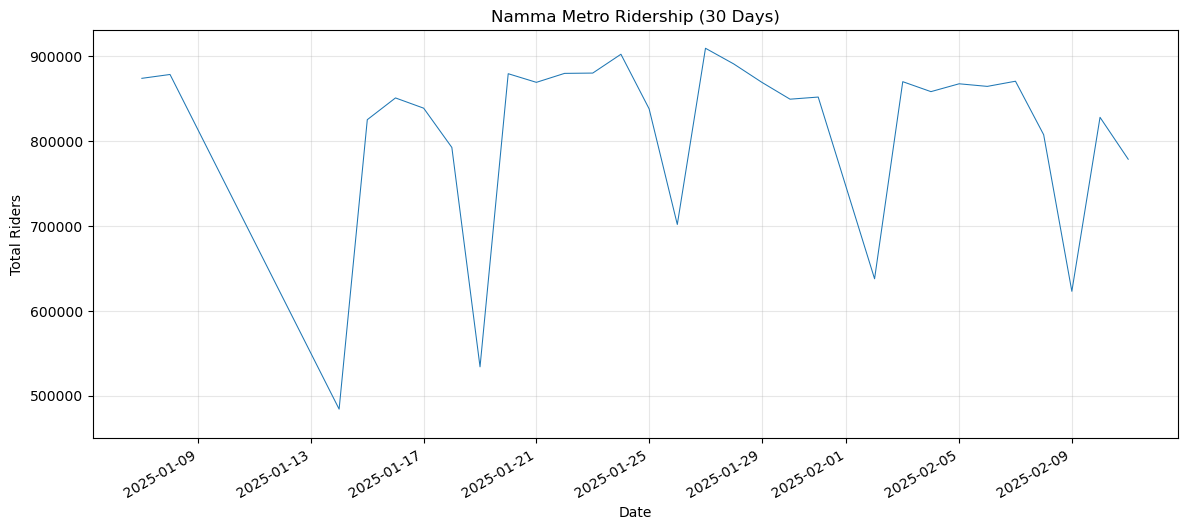

In [25]:
df.tail(30).plot(figsize=(14,6), 
                    kind='line', 
                    x='Record Date', 
                    xlabel='Date', 
                    y='Total Riders', 
                    ylabel='Total Riders', 
                    title='Namma Metro Ridership (30 Days)', 
                    legend=False,
                    linestyle='-',
                    linewidth=0.75)
plt.grid(True, alpha=0.3)
plt.ylim(bottom=450000)
plt.show()

### Let's make a cleaner graph for the last N days of available data.

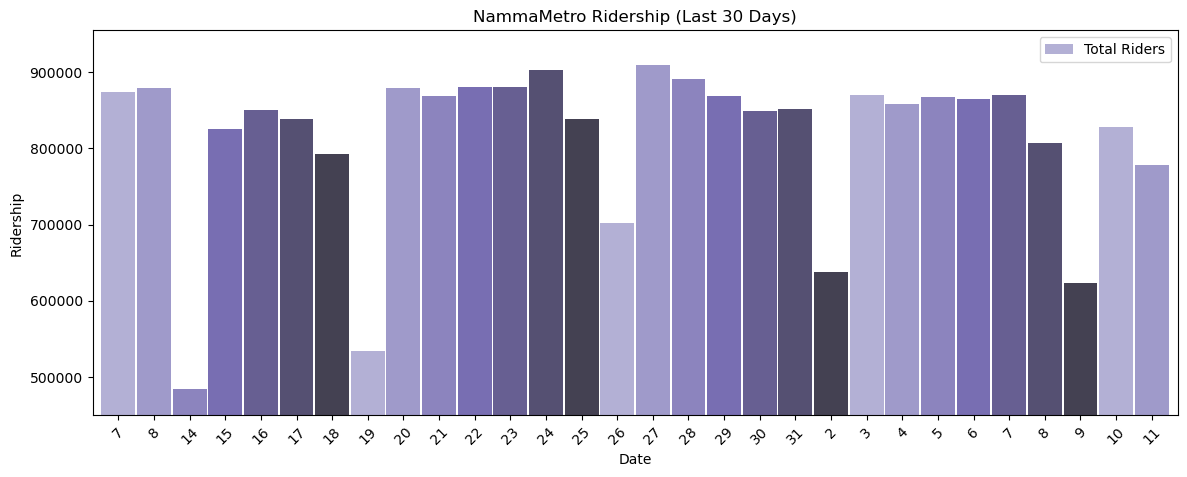

In [26]:
number_of_days = 30
Last_N_Days = df[['Record Date', 'Total Riders']].tail(number_of_days)
Last_N_Days['Record Date'] = pd.to_datetime(Last_N_Days['Record Date'], format='%d-%m-%Y').dt.day
Last_N_Days.plot(x='Record Date', 
                 y='Total Riders', 
                 kind='bar', 
                 xlabel='Date', 
                 ylabel='Ridership', 
                 title='NammaMetro Ridership (Last 30 Days)', 
                 figsize=(14,5), 
                 width=0.95,
                 legend=True,
                 color=sns.color_palette('Purples_d', 7),
                 rot=45)
plt.ylim(bottom=450000)
plt.show()

# Missing Days

NammaMetro fails to report ridership numbers on some days. Is someone updating the page manually?! 
Let's get a better understanding of that missing data.

In [27]:
from datetime import date, timedelta

start_date = date.today() - timedelta(number_of_days, 0, 0)
dates = pd.DataFrame({'Record Date': [str(start_date+timedelta(n)) for n in range(number_of_days)]})
dates['Record Date'] = pd.to_datetime(dates['Record Date'], format='%Y-%m-%d')
dates['Day of Week'] = dates['Record Date'].dt.day_name()

print(f"We will examine the data during the period of the last {number_of_days} calendar days, \
i.e. from {dates['Record Date'].min().strftime('%d-%m-%Y')} to {dates['Record Date'].max().strftime('%d-%m-%Y')}.")

We will examine the data during the period of the last 30 calendar days, i.e. from 13-01-2025 to 11-02-2025.


### Days of Missing Data

In [28]:
Last_N_Days = df.merge(dates, how='right', on='Record Date')
Last_N_Days.drop(['Stored Value Card', 'One Day Pass', 'Three Day Pass', 'Five Day Pass', 'QR NammaMetro', 'QR WhatsApp', 'QR Paytm'], axis=1, inplace=True)
Last_N_Days.rename(columns={'Total Smart Cards':'Smart Cards', 'Total NCMC':'NCMC', 'Total QR':'QR'}, inplace=True)

formatted_dates = pd.to_datetime(Last_N_Days['Record Date'], format='%Y-%m-%d').dt.strftime('%d')
formatted_numbers = Last_N_Days.loc[:, 'Smart Cards':'Total Riders'].astype('Int64')

Last_N_Days = pd.concat([formatted_dates, formatted_numbers, dates['Day of Week']], axis=1)
Last_N_Days[Last_N_Days['Total Riders'].isna()]

,Record Date,Smart Cards,Tokens,NCMC,Group Ticket,QR,Total Riders,Day of Week
0,13,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Monday
19,01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Saturday


In [29]:
# For use later when creating the stacked area chart
imputed_days = Last_N_Days['Record Date'][Last_N_Days['Total Riders'].isna()].tolist()

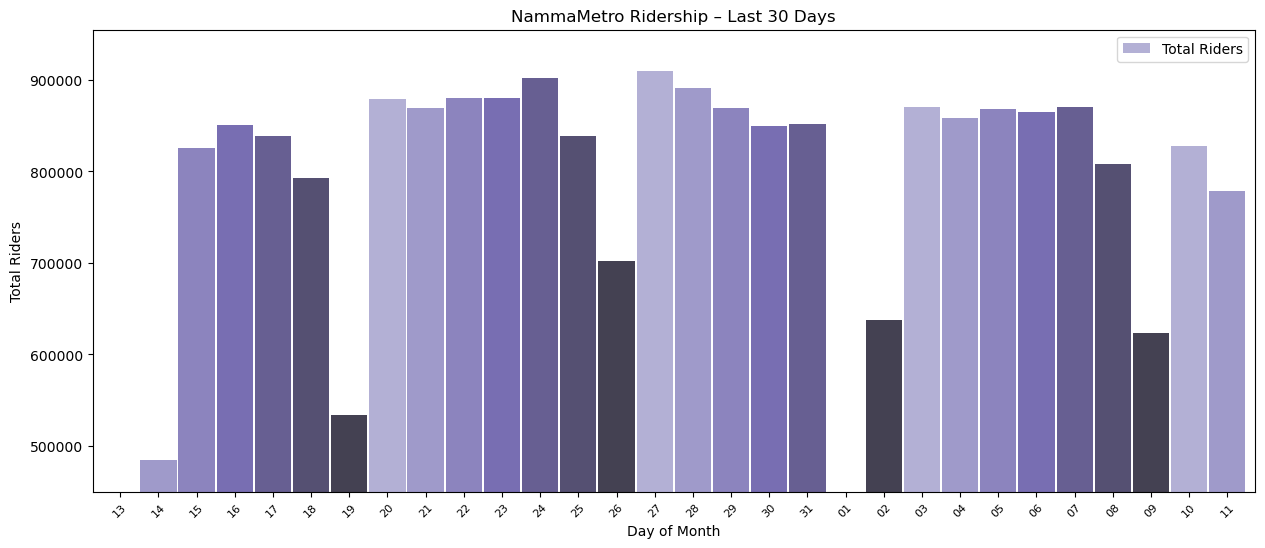

In [30]:
Last_N_Days.loc[:, :'Total Riders']\
           .plot(x='Record Date',
                 y='Total Riders',
                 kind='bar',
                 xlabel='Day of Month',
                 ylabel='Total Riders',
                 title='NammaMetro Ridership – Last 30 Days', 
                 figsize=(15,6),
                 width=0.95,
                 color=sns.color_palette('Purples_d', 7),
                 legend=True,
                 rot=45)
plt.ylim(bottom=450000)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.show()

### Looks like a mouth with a few broken teeth!

What sort of data imputation makes sense here? 

When the dataset grows large enough over several months, it makes sense to fill unreported dates with an average of similar days, e.g. If a weekday Tuesday was missing, take the average of the last 4 available weekday Tuesdays.

_____
## One Week on NammaMetro

### Smart Cards and Tokens are very popular with the public. Digital payments (QR and NCMC) are on the rise

In [31]:
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%Y-%m-%d')
df['Day of Week'] = df['Record Date'].dt.day_name()
df['Day of Week'].value_counts()[['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']]

Day of Week
Sunday       13
Saturday     14
Friday       13
Thursday     12
Wednesday    12
Tuesday      16
Monday       13
Name: count, dtype: int64

In [32]:
weekly_average = df.merge(dates, how='right', on='Record Date')
weekly_average.drop(['Stored Value Card', 'One Day Pass', 'Three Day Pass', 'Five Day Pass', 'QR NammaMetro', 'QR WhatsApp', 'QR Paytm', 'Day of Week_x'], axis=1, inplace=True)
weekly_average.rename(columns={'Total Smart Cards':'Smart Cards', 'Total NCMC':'NCMC', 'Total QR':'QR', 'Day of Week_y':'Day of Week'}, inplace=True)

weekly_average = weekly_average.groupby('Day of Week')[['Smart Cards', 'Tokens', 'Group Ticket', 'QR', 'NCMC']].mean()
weekly_average = weekly_average.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

for col in ['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR']:
    weekly_average[col] = pd.to_numeric(weekly_average[col].fillna(0), errors='coerce').round().astype('Int64')

weekly_average['Total Riders'] = weekly_average.sum(axis=1)
weekly_average

,Smart Cards,Tokens,Group Ticket,QR,NCMC,Total Riders
Day of Week,,,,,,
Monday,446328,210510,246,198921,15834,871839
Tuesday,394294,190953,324,176589,14234,776394
Wednesday,489042,165581,296,190180,15486,860585
Thursday,502964,194992,518,146818,16060,861352
Friday,437484,205952,652,206683,15260,866031
Saturday,300849,250772,650,249917,10635,812823
Sunday,171555,238733,510,207585,5877,624260


### 👆🏼 NammaMetro is the officegoers commute of choice as seen by its popularity on weekdays.

From Monday to Friday, the daily ridership consistently exceeds 800,000. 

On the weekends, traffic eases but only slightly. Saturday is still a working day for many in this city. 

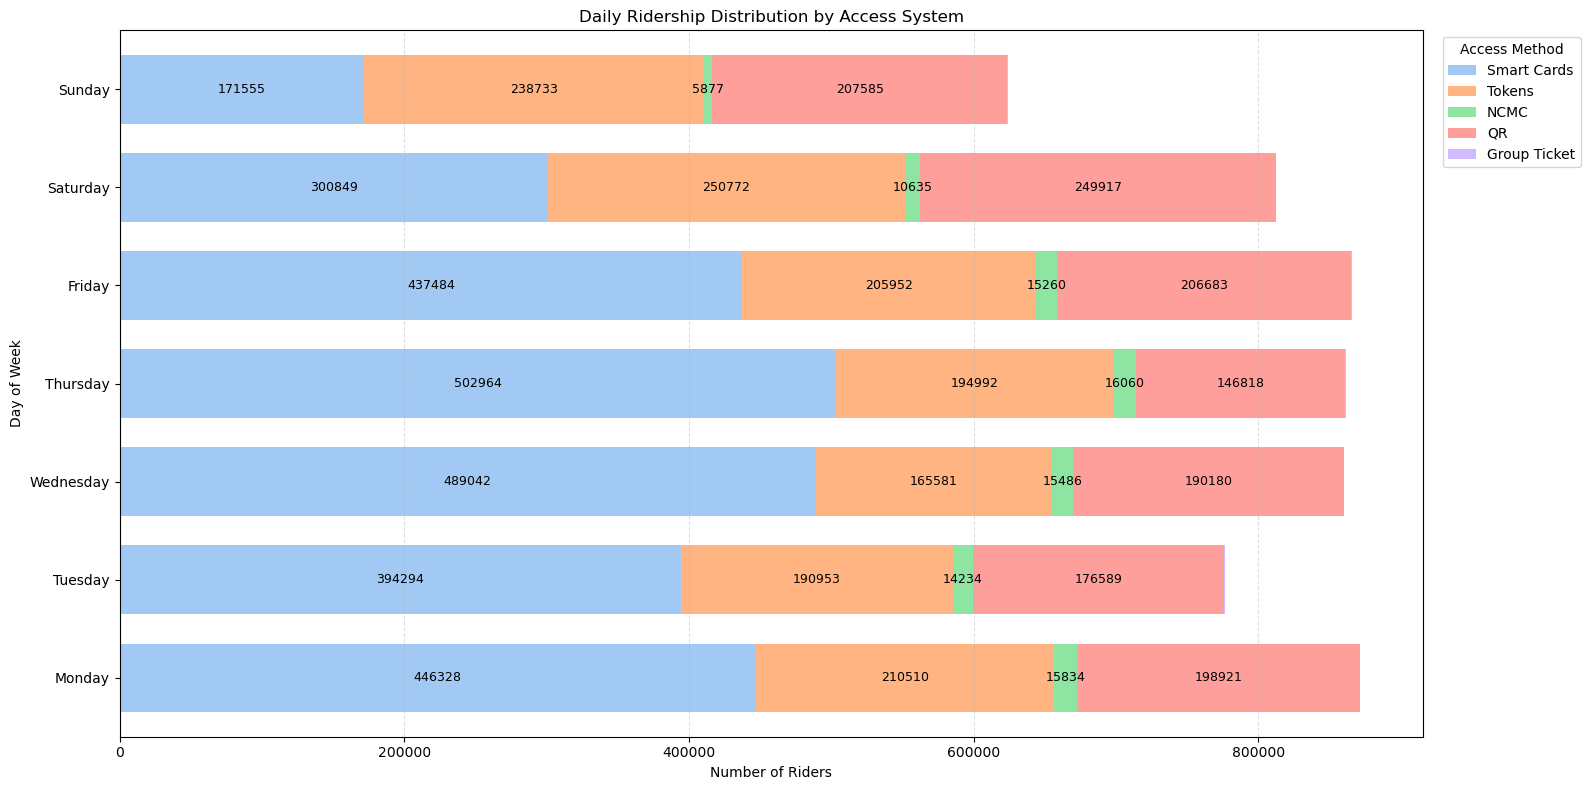

In [33]:
ax = weekly_average.loc[:, ['Smart Cards', 'Tokens', 'NCMC', 'QR', 'Group Ticket']].plot(kind='barh', 
                         stacked=True,
                         color=sns.color_palette('pastel', 5),
                         figsize=(16, 8),
                         width=0.7,
                         rot=0)

plt.title('Daily Ridership Distribution by Access System')
plt.ylabel('Day of Week')
plt.xlabel('Number of Riders')
plt.legend(title='Access Method', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.4)

for c in ax.containers:
    labels = ['%.0f' % v if v >= 4000 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=9)

plt.tight_layout()
plt.show()

### 👆🏼 Surprising find — Smart Card usage peaks during the week, Token usage peaks on weekends.

- Smart Cards and NCMC are typically used by regular metro riders. 

- From Monday to Friday, Smart Card usage crosses 400,000 and NCMC usage exceeds 10,000. 

- Together they reconfirm the finding that **NammaMetro is popular with officegoers for their daily commute**.

- Tokens and QR are typically used by non-regular metro riders.

- This could suggest **weekend demand is driven by casual users**, e.g. road commuters who prefer using public transport on the weekends.

- On the weekends, traffic eases but only slightly. Saturday is still a working day for many in this city. 

_____

![Crossed daily ridership of 700,000 in October 2023](nammametro_record1.png)

## The Metro is Getting Crowded

### Top 10 Busiest Days - Commuter Traffic

In [34]:
busiest_days = df[['Record Date', 'Total Riders', 'Day of Week']].sort_values('Total Riders', ascending=False)
busiest_days.reset_index(drop=True, inplace=True)
busiest_days.index = range(1, len(busiest_days) + 1)
busiest_days.head(25)

,Record Date,Total Riders,Day of Week
1,2025-01-27,909522,Monday
2,2024-12-10,903928,Tuesday
3,2025-01-24,902476,Friday
4,2024-12-04,901475,Wednesday
5,2024-12-05,901230,Thursday
6,2024-12-09,895461,Monday
7,2025-01-28,891111,Tuesday
8,2024-12-13,890143,Friday
9,2024-11-19,889113,Tuesday
10,2024-12-07,883300,Saturday


### 👆🏼 In December 2024, NammaMetro single-day ridership crossed 900,000 for the first time!

The ridership hit a record of 700,000 passengers in October 2023. It took just a little over a year to add 200,000 riders/day to the system.

### Least Busy Days so far - Weekend Traffic

In [35]:
busiest_days.tail(10)

,Record Date,Total Riders,Day of Week
84,2024-10-27,637048,Sunday
85,2025-01-05,629755,Sunday
86,2025-02-09,623123,Sunday
87,2024-12-29,600289,Sunday
88,2024-12-01,575702,Sunday
89,2024-11-03,536524,Sunday
90,2025-01-19,534139,Sunday
91,2025-01-14,484293,Tuesday
92,2024-11-02,480284,Saturday
93,2024-11-01,404342,Friday


______

## One Month on NammaMetro

In [36]:
df[df['Record Date'] >= '2024-11-01'].groupby(df['Record Date'].dt.to_period('M'))['Total Riders'].sum().astype('Int64')

Record Date
2024-11    19717435
2024-12    22363482
2025-01    20230727
2025-02     8007093
Freq: M, Name: Total Riders, dtype: Int64

Monthly ridership totals calulated from the data is bound to be inaccurate as NammaMetro fails to report ridership numbers on some days.

Official monthly ridership as reported on the NammaMetro website is as follows:

**Month**      | **Ridership**
---------------|---------------
2024 July      | 23,633,166
2024 August    | Unavailable
2024 September | 23,072,685
2024 October   | Unavailable
2024 November  | 23,613,895
2024 December  | 24,982,906
2025 January   | 24,914,736


#### Prepare the data to plot a bar chart stacked by access method

#### Impute missing data with the average of similar days

In [37]:
Last_N_Days = Last_N_Days.set_index('Day of Week')
Last_N_Days.fillna(weekly_average, inplace=True)
Last_N_Days.reset_index(inplace=True)
Last_N_Days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Day of Week   30 non-null     object
 1   Record Date   30 non-null     object
 2   Smart Cards   30 non-null     Int64 
 3   Tokens        30 non-null     Int64 
 4   NCMC          30 non-null     Int64 
 5   Group Ticket  30 non-null     Int64 
 6   QR            30 non-null     Int64 
 7   Total Riders  30 non-null     Int64 
dtypes: Int64(6), object(2)
memory usage: 2.2+ KB


In [38]:
Last_N_Days_melt = Last_N_Days.melt(
                    id_vars=['Record Date'], 
                    value_vars=['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR'], 
                    var_name='Access Method', 
                    value_name='Count')
Last_N_Days_melt

,Record Date,Access Method,Count
0,13,Smart Cards,446328
1,14,Smart Cards,138529
2,15,Smart Cards,543080
3,16,Smart Cards,631442
4,17,Smart Cards,437788
...,...,...,...
145,07,QR,211050
146,08,QR,264937
147,09,QR,207621
148,10,QR,180897


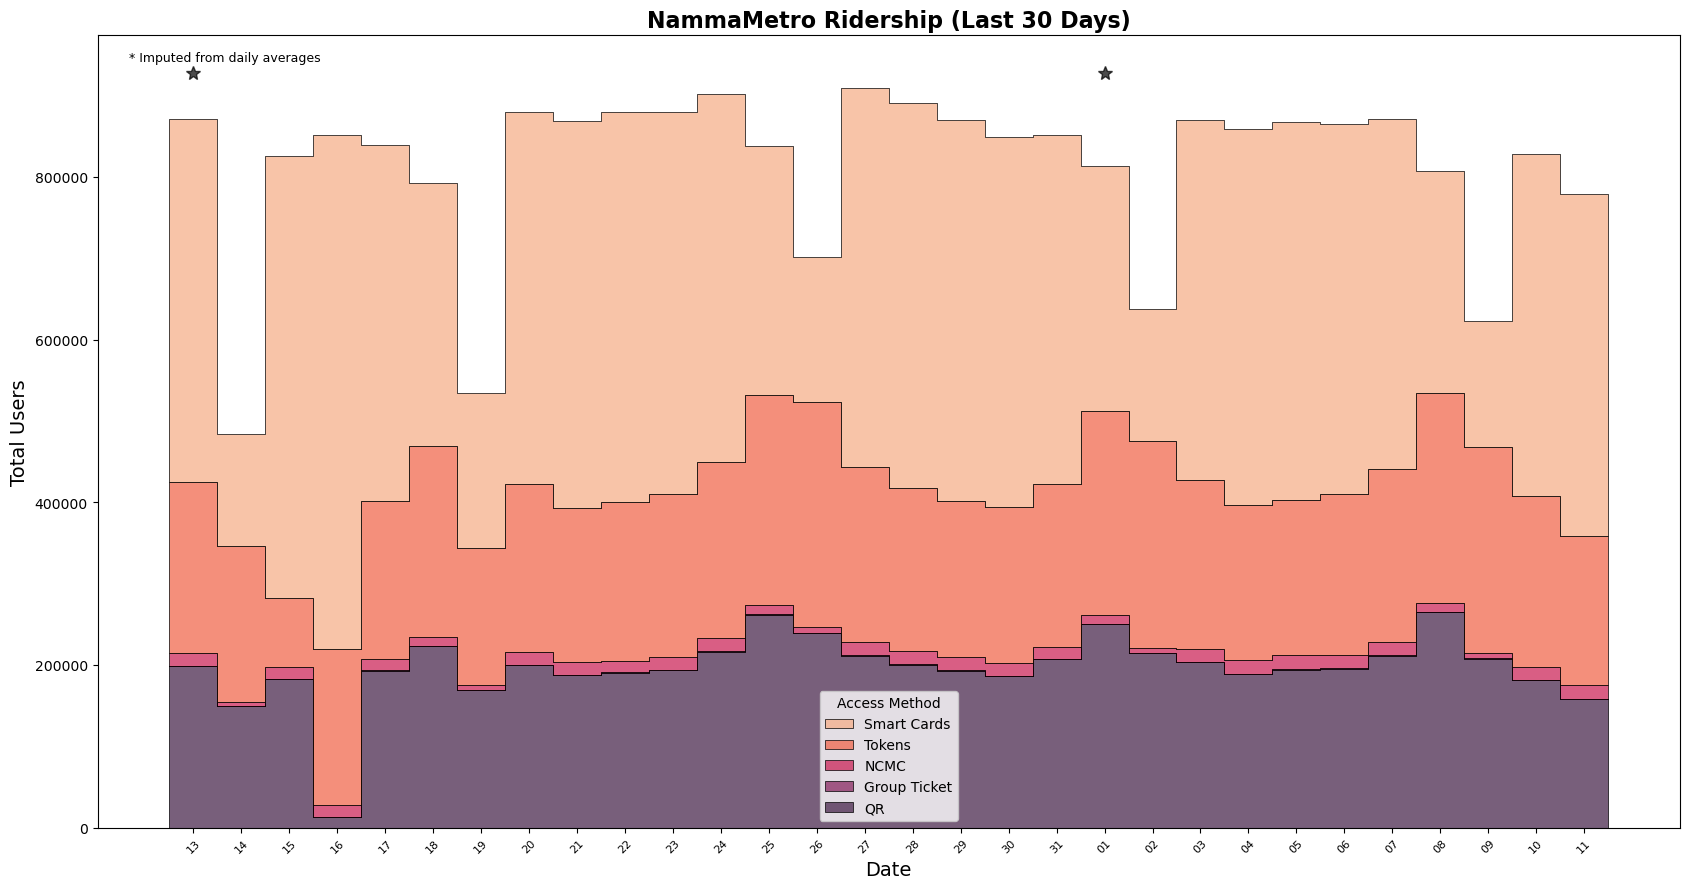

In [39]:
Last_N_Days_melt = Last_N_Days_melt.replace([np.inf, -np.inf], np.nan)
import warnings

# Creating the stacked area plot
plt.figure(figsize=(17,9))

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    sns.histplot(data=Last_N_Days_melt, x='Record Date',
                weights='Count',       bins=number_of_days,
                hue='Access Method',   multiple='stack', 
                element='step',        palette='rocket_r',
                legend=True,           common_norm=True,
                stat='count',          linewidth=0.5,
                alpha=0.7,             discrete=True, 
                kde=False)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Users', fontsize=14)
plt.title(f'NammaMetro Ridership (Last {number_of_days} Days)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)

# Get the y-coordinate for the markers (slightly above the highest point)
y_max = Last_N_Days[['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR']].sum(axis=1).max()
marker_y = y_max * 1.02  # Place markers 2% above the highest point

# Add markers for imputed data
for day in imputed_days:
    plt.plot(day, marker_y, 'k*', markersize=10, alpha=0.7)

# Add a note in the legend or as text
plt.text(0.02, 0.98, '* Imputed from daily averages', 
         transform=plt.gca().transAxes, 
         fontsize=9, 
         verticalalignment='top')

plt.tight_layout()
plt.show()

In [40]:
access_method = 'NCMC'

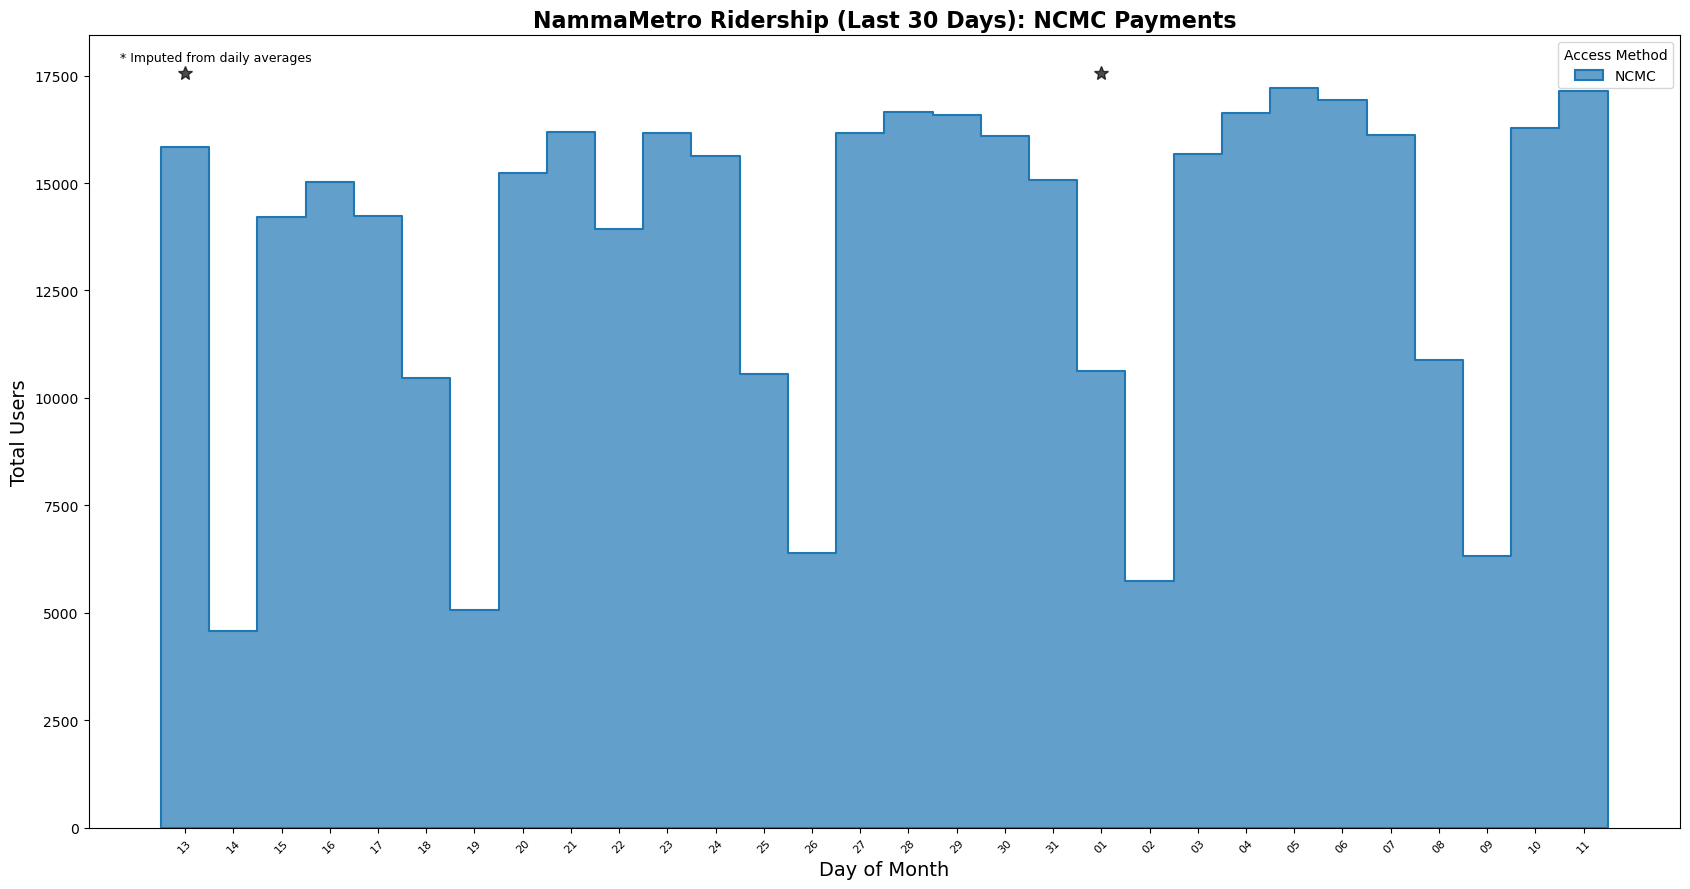

In [41]:
# Creating the stacked area plot
plt.figure(figsize=(17,9))

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    sns.histplot(data=Last_N_Days_melt[Last_N_Days_melt['Access Method'] == access_method], x='Record Date',
                weights='Count',       bins=number_of_days,
                hue='Access Method',    
                element='step',        
                legend=True,           common_norm=True,
                stat='count',          linewidth=1.5,
                alpha=0.7,             discrete=True, 
                kde=False)
plt.xlabel('Day of Month', fontsize=14)
plt.ylabel('Total Users', fontsize=14)
plt.title(f'NammaMetro Ridership (Last {number_of_days} Days): {access_method} Payments', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)

# Get the y-coordinate for the markers (slightly above the highest point)
y_max = Last_N_Days[[access_method]].sum(axis=1).max()
marker_y = y_max * 1.02  # Place markers 2% above the highest point

# Add markers for imputed data
for day in imputed_days:
    plt.plot(day, marker_y, 'k*', markersize=10, alpha=0.7)

# Add a note in the legend or as text
plt.text(0.02, 0.98, '* Imputed from daily averages', 
         transform=plt.gca().transAxes, 
         fontsize=9, 
         verticalalignment='top')

plt.tight_layout()
plt.show()

# Key Insights – The Metro's Dual Role

**Holiday Usage Patterns**

- New Year's Eve (31st): Notable spike in ridership, particularly in Tokens and QR tickets, indicating heavy use by occasional riders for celebrations

- Sankranti (14th): Slight dip in ridership, but not as pronounced as might be expected for a major festival, possibly because it's primarily a home-based celebration

- While Smart Card usage drops (fewer office commuters), it's offset by increases in Tokens and QR tickets

- This suggests the metro serves different user segments on holidays:

    - Weekdays: Dominated by commuters with Smart Cards

    - Holidays/Weekends: More leisure travelers, shoppers, and tourists using single-journey options

    - #### The total ridership staying "normal" is about the metro's dual role as a commuter necessity on weekdays and a convenient transport option for casual users on weekends and holidays.

**Payment Method Trends**

- Smart Cards consistently dominate weekday ridership, showing strong commuter base

- Tokens and QR show inverse relationship with Smart Cards - higher on weekends/holidays

- #### This switching pattern shows how the same infrastructure serves different urban needs at different times. The consistent total ridership across different days suggests the metro is well-integrated into both work and leisure travel patterns in Bengaluru

- The QR anomaly on the 16th is particularly interesting - such a sharp drop in QR usage might indicate a technical issue with the QR payment system that day

**Weekly Patterns**

- Clear weekend dips in Smart Card usage

- Compensatory increases in Token and NCMC usage during weekends, suggesting more casual travelers

**Overall Volume Insights**

- Daily ridership typically fluctuates between 600,000 to 800,000 passengers

- Weekday peaks are driven primarily by Smart Card users (regular commuters)

- Holiday periods don't necessarily mean lower ridership - they just show different payment method distributions

- This visualization effectively shows how metro usage patterns reflect both the working rhythm of the city and its cultural calendar.